In [1]:
from collections import defaultdict
import pickle

import matplotlib.pyplot as plt
from matplotlib.ticker import EngFormatter
import numpy as np
from obp.utils import estimate_confidence_interval_by_bootstrap
import pandas as pd
import seaborn as sns

pal = sns.color_palette("colorblind", 17)

%matplotlib inline
%config InlineBackend.figure_format = "retina"

Load experiment results

In [2]:
with open("../results_deezer_1_7.pickle", "rb") as f:
    deezer_a = pickle.load(f)
    # delete aborted stuff
    del deezer_a["policy_feedback"]["linear_epsilon_greedy_0.01"]
    deezer_a["policies"] = [policy for i, policy in enumerate(deezer_a["policies"]) if i < 8]
    
with open("../results_deezer_8_17.pickle", "rb") as f:
    deezer_b = pickle.load(f)
    
with open("../results_obp_basic.pickle", "rb") as f:
    obp = pickle.load(f)

Combine deezer results and split into contextfree vs contextual/segmented

In [3]:
dfs_deezer = {}
for policy, feedback in deezer_a["policy_feedback"].items():
    dfs_deezer[policy] = (
        pd.DataFrame(
            {
                "reward": feedback["reward"],
                "batch": feedback["batches"],
            }
        )
        .groupby("batch")
        .sum()
    )
for policy, feedback in deezer_b["policy_feedback"].items():
    dfs_deezer[policy] = (
        pd.DataFrame(
            {
                "reward": feedback["reward"],
                "batch": feedback["batches"],
            }
        )
        .groupby("batch")
        .sum()
    )

dfs_deezer["lin_egreedy_exploit"] = dfs_deezer["linear_epsilon_greedy_0.01"]
del dfs_deezer["linear_epsilon_greedy_0.01"]
dfs_deezer["lin_egreedy_explore"] = dfs_deezer["linear_epsilon_greedy_0.1"]
del dfs_deezer["linear_epsilon_greedy_0.1"]
dfs_deezer["kl_ucb"] = dfs_deezer["kl_ucp"]
del dfs_deezer["kl_ucp"]
dfs_deezer["seg_kl_ucb"] = dfs_deezer["seg_kl_ucp"]
del dfs_deezer["seg_kl_ucp"]
    
# split into context free and contextual
dfs_deezer_contextfree = {
    policy_name: df
    for policy_name, df in dfs_deezer.items()
    if policy_name[:3] not in ("seg", "lin")
}
dfs_deezer_contextual = {
    policy_name: df
    for policy_name, df in dfs_deezer.items()
    if (policy_name[:3] in ("seg", "lin")) or policy_name == "random"
}

Plotting functions

In [4]:
def cumulative_rewards(
    rewards_dict,
    title,
    path,
    mode="deezer",
    users_per_batch=(20000, 1000),
    ext_legend=False,
    legend_loc="best",
):
    fig, ax = plt.subplots(figsize=(8, 4.5))
    for i, (policy, reward) in enumerate(rewards_dict.items()):
        values = reward.cumsum()
        if (mode == "deezer") and policy[:3] == "lin":
            values *= users_per_batch[0] / users_per_batch[1]
            policy += "*"
        ax.plot(values, label=policy, color=pal[i])
    if ext_legend:
        ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
    else:
        ax.legend(loc=legend_loc)
    if mode == "deezer":
        ax.set_xlabel("batch", size=12)
        ax.set_ylabel("cumulative reward", size=12)
    else:
        ax.set_xlabel("round", size=12)
        ax.set_ylabel("est. cumulative reward", size=12)
    ax.set_title(title, size=14)
    ax.yaxis.set_major_formatter(EngFormatter(sep=""))
    if mode == "obp":
        ax.xaxis.set_major_formatter(EngFormatter(sep=""))
    fig.tight_layout()
    plt.savefig(path, dpi=300)


In [5]:
def rolling_mean_rewards(
    rewards_dict,
    title,
    path,
    window=5,
    mode="deezer",
    users_per_batch=(20000,1000),
    ext_legend=False,
    legend_loc="best",
):
    fig, ax = plt.subplots(figsize=(8, 4.5))
    for i, (policy, reward) in enumerate(rewards_dict.items()):
        values = reward.rolling(window).mean()
        if mode == "deezer": 
            if policy[:3] == "lin":
                values /= users_per_batch[1]
                policy += "*"
            else:
                values /= users_per_batch[0]
        ax.plot(values, label=policy, color=pal[i])
    if ext_legend:
        ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
    else:
        ax.legend(loc=legend_loc)
    if mode == "deezer":
        ax.set_xlabel(f"batch (rolling window of {window})", size=12)
        ax.set_ylabel("rolling mean reward per batch", size=12)
    else:
        ax.set_xlabel(f"round (rolling window of {window})", size=12)
        ax.set_ylabel("est. rolling mean reward", size=12)
    if mode == "obp":
        ax.xaxis.set_major_formatter(EngFormatter(sep=""))
    ax.set_title(title, size=14)
    fig.tight_layout()
    plt.savefig(path, dpi=300)

In [6]:
def running_mean_rewards(
    rewards_dict, title, path, mode="deezer", users_per_batch=(20000, 1000), ext_legend=False, legend_loc="best"
):
    fig, ax = plt.subplots(figsize=(8, 4.5))
    for i, (policy, reward) in enumerate(rewards_dict.items()):
        values = reward.expanding().mean()
        if mode == "deezer":
            if policy[:3] == "lin":
                values /= users_per_batch[1]
                policy += "*"
            else:
                values /= users_per_batch[0]
        ax.plot(values, label=policy, color=pal[i])
    ax.legend()
    ax.set_xlabel("batch", size=12)
    if ext_legend:
        ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
    else:
        ax.legend(loc=legend_loc)
    if mode == "deezer":
        ax.set_xlabel(f"batch", size=12)
        ax.set_ylabel("running mean reward per batch", size=12)
    else:
        ax.set_xlabel(f"round", size=12)
        ax.set_ylabel("est. running mean reward", size=12)
    if mode == "obp":
        ax.xaxis.set_major_formatter(EngFormatter(sep=""))
    ax.set_title(title, size=14)
    fig.tight_layout()
    plt.savefig(path, dpi=300)

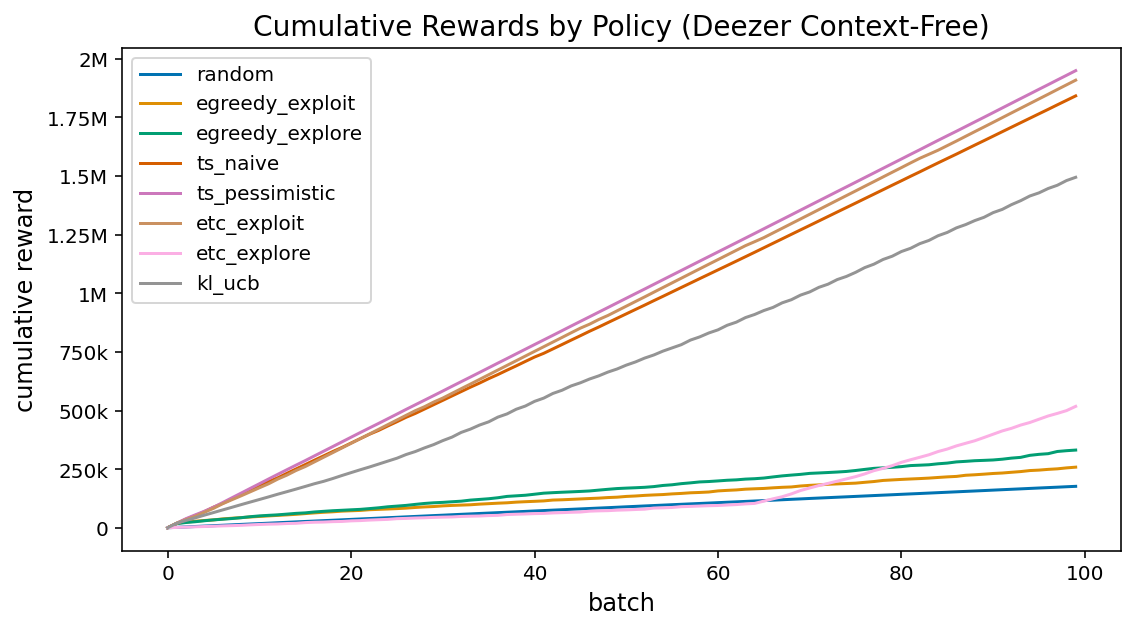

In [7]:
cumulative_rewards(
    dfs_deezer_contextfree,
    "Cumulative Rewards by Policy (Deezer Context-Free)",
    "../figures/deezer_cumulative_cf.png",
)

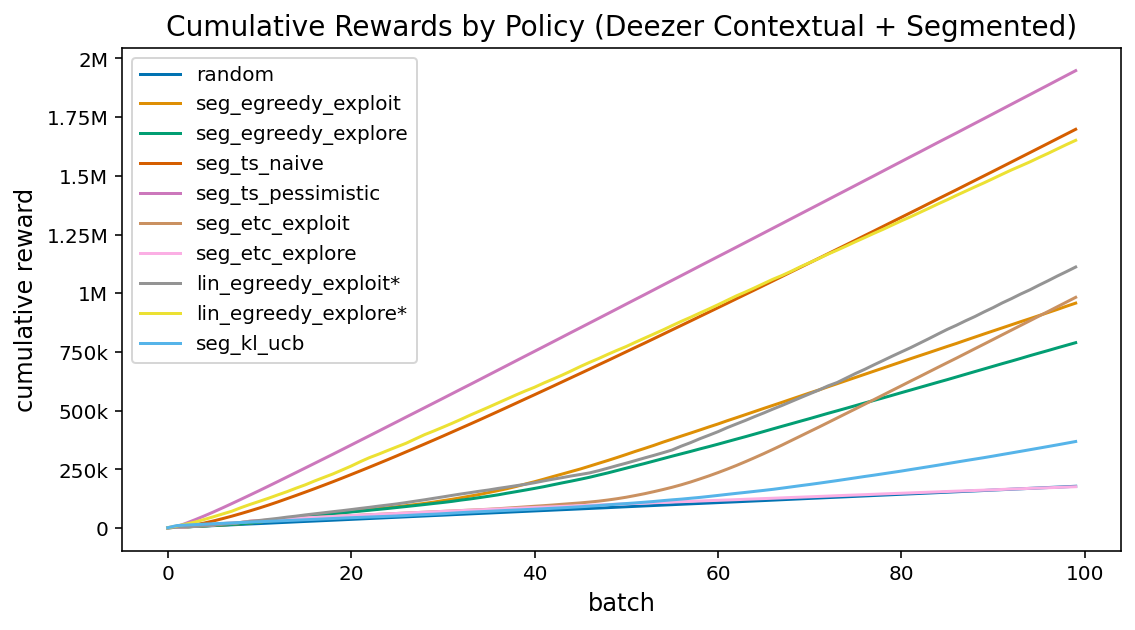

In [8]:
cumulative_rewards(
    dfs_deezer_contextual,
    "Cumulative Rewards by Policy (Deezer Contextual + Segmented)",
    "../figures/deezer_cumulative_con.png",
)

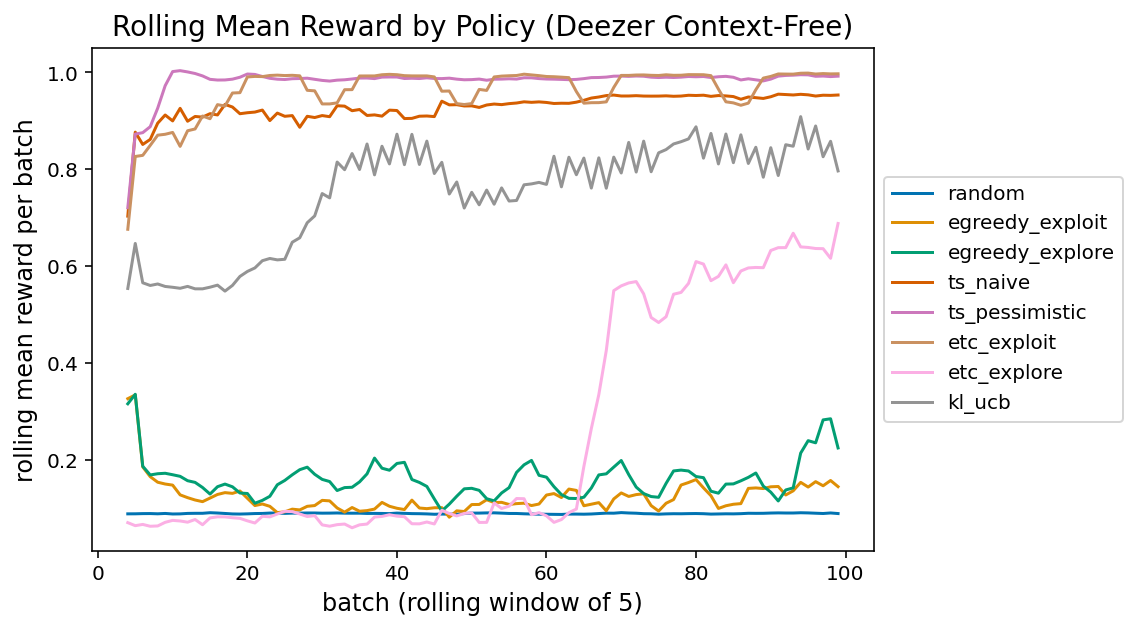

In [9]:
rolling_mean_rewards(
    dfs_deezer_contextfree,
    "Rolling Mean Reward by Policy (Deezer Context-Free)",
    "../figures/deezer_roll_cf.png",
    window=5,
    ext_legend=True,
)

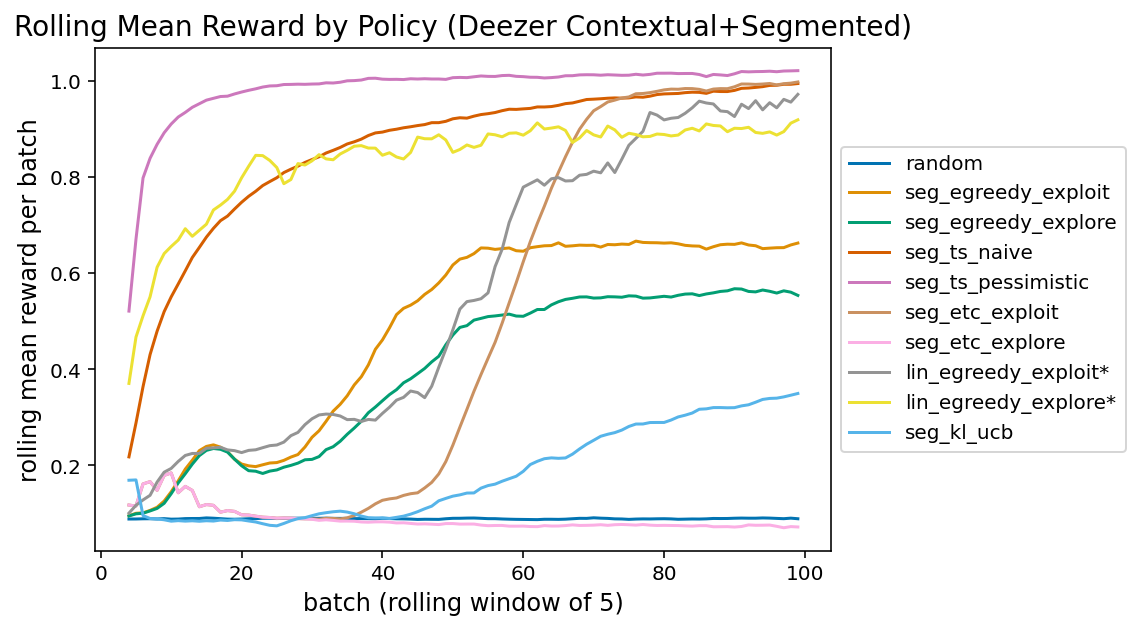

In [10]:
rolling_mean_rewards(
    dfs_deezer_contextual,
    "Rolling Mean Reward by Policy (Deezer Contextual+Segmented)",
    "../figures/deezer_roll_con.png",
    window=5,
    ext_legend=True,
)

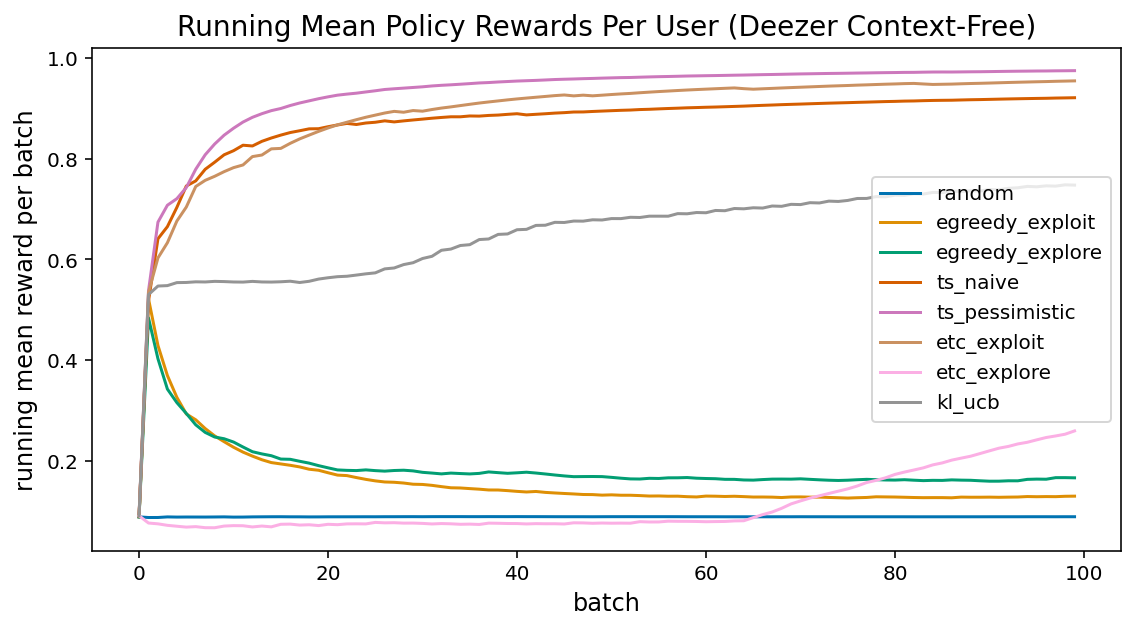

In [11]:
running_mean_rewards(
    dfs_deezer_contextfree,
    "Running Mean Policy Rewards Per User (Deezer Context-Free)",
    "../figures/deezer_run_cf.png",
)

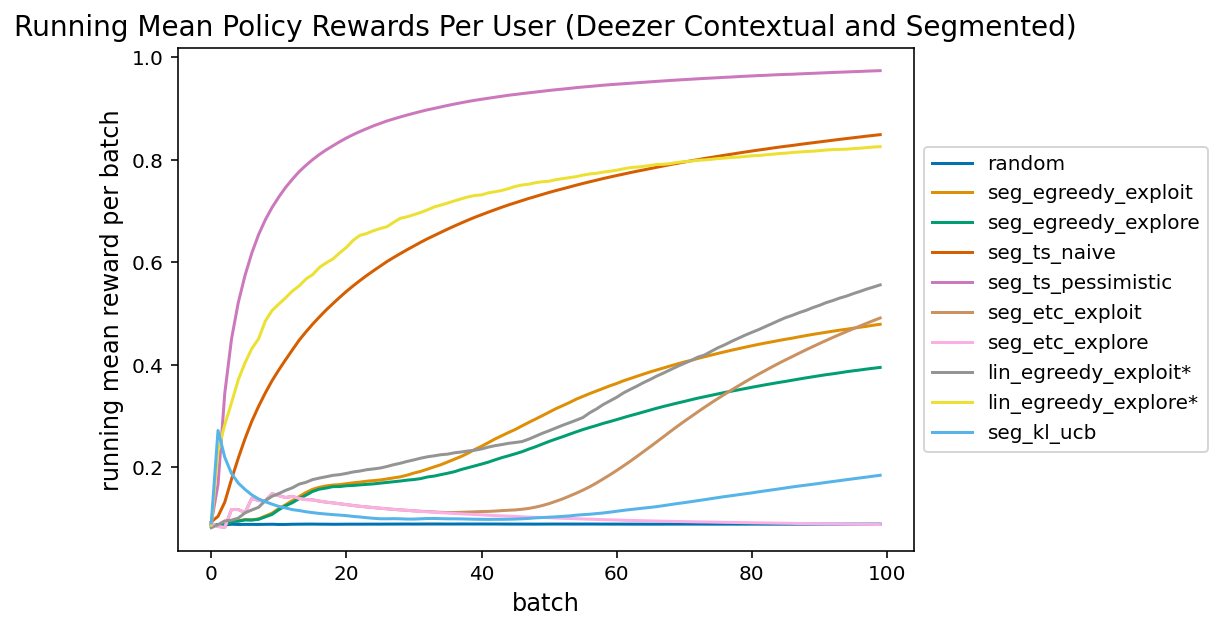

In [12]:
running_mean_rewards(
    dfs_deezer_contextual,
    "Running Mean Policy Rewards Per User (Deezer Contextual and Segmented)",
    "../figures/deezer_run_con.png",
    ext_legend=True,
)

Set up OBP data

In [13]:
obp["policy_feedback"]["kl_ucb"] = obp["policy_feedback"]["kl_ucp"]
del obp["policy_feedback"]["kl_ucp"]
obp["policy_feedback"]["lin_egreedy_exploit"] = obp["policy_feedback"]["linear_epsilon_greedy_0.01"]
del obp["policy_feedback"]["linear_epsilon_greedy_0.01"]
obp["policy_feedback"]["lin_egreedy_explore"] = obp["policy_feedback"]["linear_epsilon_greedy_0.1"]
del obp["policy_feedback"]["linear_epsilon_greedy_0.1"]


rewards_obp_replay = {}

for policy, feedback in obp["policy_feedback"].items():
    if isinstance(feedback["reward"], np.ndarray):
        rewards_obp_replay[policy] = pd.Series(feedback["reward"])
    else:
        rewards_obp_replay[policy] = pd.Series(feedback["reward"]["ReplayMethod"])

rewards_obp_ipw = {}
for policy, feedback in obp["policy_feedback"].items():
    if isinstance(feedback["reward"], np.ndarray):
        rewards_obp_ipw[policy] = pd.Series(feedback["reward"])
    else:
        rewards_obp_ipw[policy] = pd.Series(feedback["reward"]["InverseProbabilityWeighting"])
        
rewards_obp_snipw = {}
for policy, feedback in obp["policy_feedback"].items():
    if isinstance(feedback["reward"], np.ndarray):
        rewards_obp_snipw[policy] = pd.Series(feedback["reward"])
    else:
        rewards_obp_snipw[policy] = pd.Series(feedback["reward"]["SelfNormalizedInverseProbabilityWeighting"])
        
rewards_obp_dm = {}
for policy, feedback in obp["policy_feedback"].items():
    if isinstance(feedback["reward"], np.ndarray):
        rewards_obp_dm[policy] = pd.Series(feedback["reward"])
    else:
        rewards_obp_dm[policy] = pd.Series(feedback["reward"]["DirectMethod"])

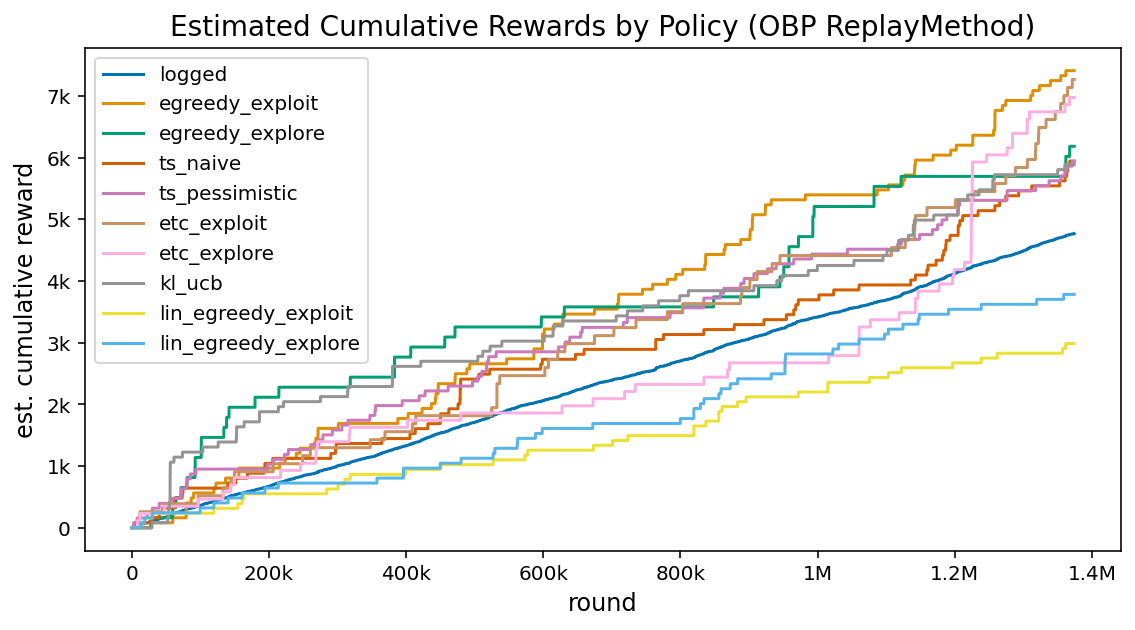

In [14]:
cumulative_rewards(
    rewards_obp_replay,
    "Estimated Cumulative Rewards by Policy (OBP ReplayMethod)",
    "../figures/obp_cumul_replay.png",
    mode="obp",
)

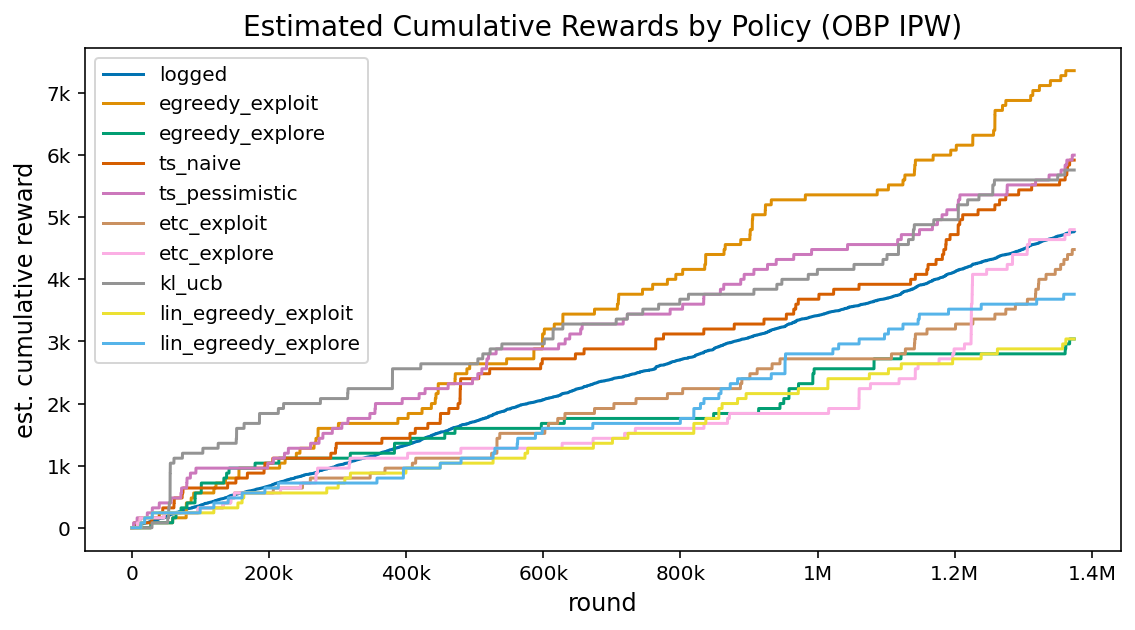

In [15]:
cumulative_rewards(
    rewards_obp_ipw,
    "Estimated Cumulative Rewards by Policy (OBP IPW)",
    "../figures/obp_cumul_ipw.png",
    mode="obp",
)

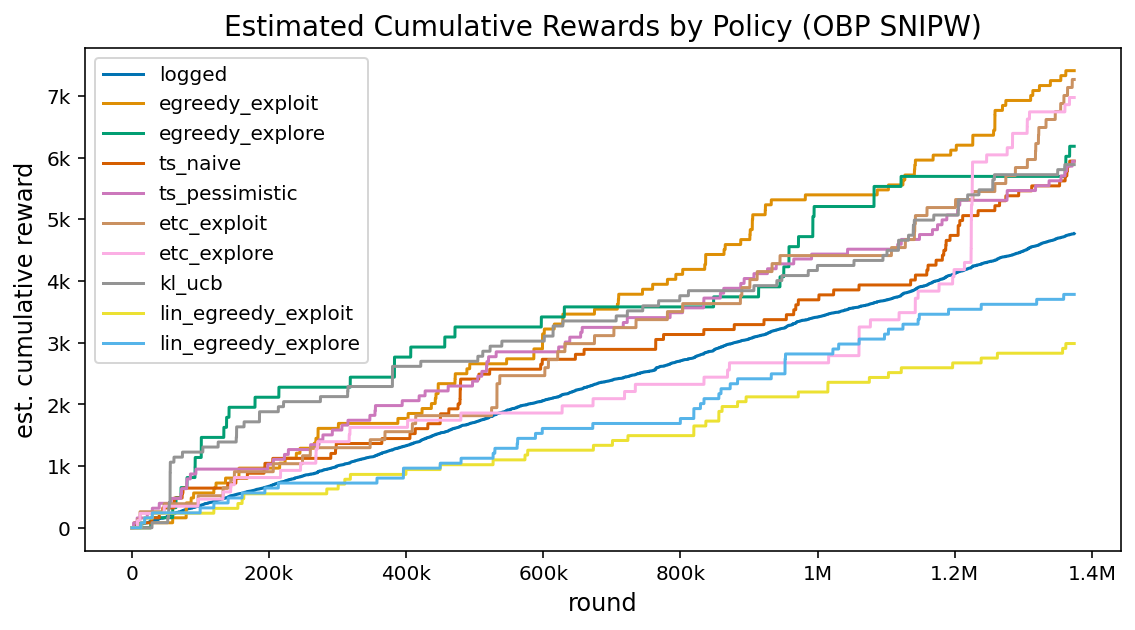

In [16]:
cumulative_rewards(
    rewards_obp_snipw,
    "Estimated Cumulative Rewards by Policy (OBP SNIPW)",
    "../figures/obp_cumul_snipw.png",
    mode="obp",
    ext_legend=False,
    legend_loc="upper left"
)

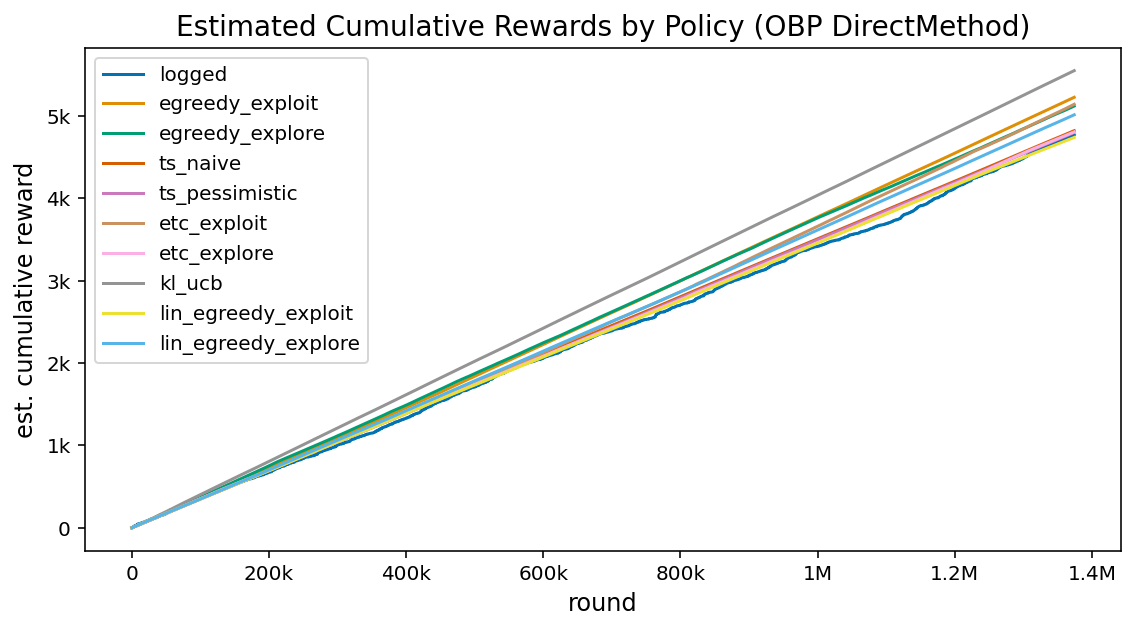

In [17]:
cumulative_rewards(
    rewards_obp_dm,
    "Estimated Cumulative Rewards by Policy (OBP DirectMethod)",
    "../figures/obp_cumul_dm.png",
    mode="obp",
)

Accidentally forgot to save separate reward summaries for each estimator, so let's regenerate them:

In [18]:
def recursive_defaultdict():
    return defaultdict(recursive_defaultdict)


reward_summary = recursive_defaultdict()

for i, (policy, feedback) in enumerate(obp["policy_feedback"].items()):
    if policy == "logged":
        reward_summary[policy] = estimate_confidence_interval_by_bootstrap(
            feedback["reward"], n_bootstrap_samples=100, random_state=i
        )
    else:
        for estimator, reward in feedback["reward"].items():
            reward_summary[policy][
                estimator
            ] = estimate_confidence_interval_by_bootstrap(
                reward, n_bootstrap_samples=100, random_state=i
            )

Make a reward summary dict for each estimator

In [19]:
means = defaultdict(list)
cis = defaultdict(list)
yerr = defaultdict(list)
policies = list(reward_summary.keys())
estimators = list(reward_summary["kl_ucb"].keys())
for policy, summary in reward_summary.items():
    if policy == "logged":
        for estimator in estimators:
            means[estimator].append(summary["mean"])
            cis[estimator].append((summary["95.0% CI (lower)"], summary["95.0% CI (upper)"]))
    else:
        for estimator, summary_ in summary.items():
            means[estimator].append(summary_["mean"])
            cis[estimator].append((summary_["95.0% CI (lower)"], summary_["95.0% CI (upper)"]))

Make all means, CIs, and errors relative

In [20]:
baseline = obp["reward_summary"]["logged"]["mean"]
for estimator in estimators:
    cis[estimator] = np.array(cis[estimator]) / baseline
    means[estimator] = np.array(means[estimator]) / baseline
    yerr[estimator] = np.abs(np.tile(means[estimator], (2, 1)).T - cis[estimator])

Plot

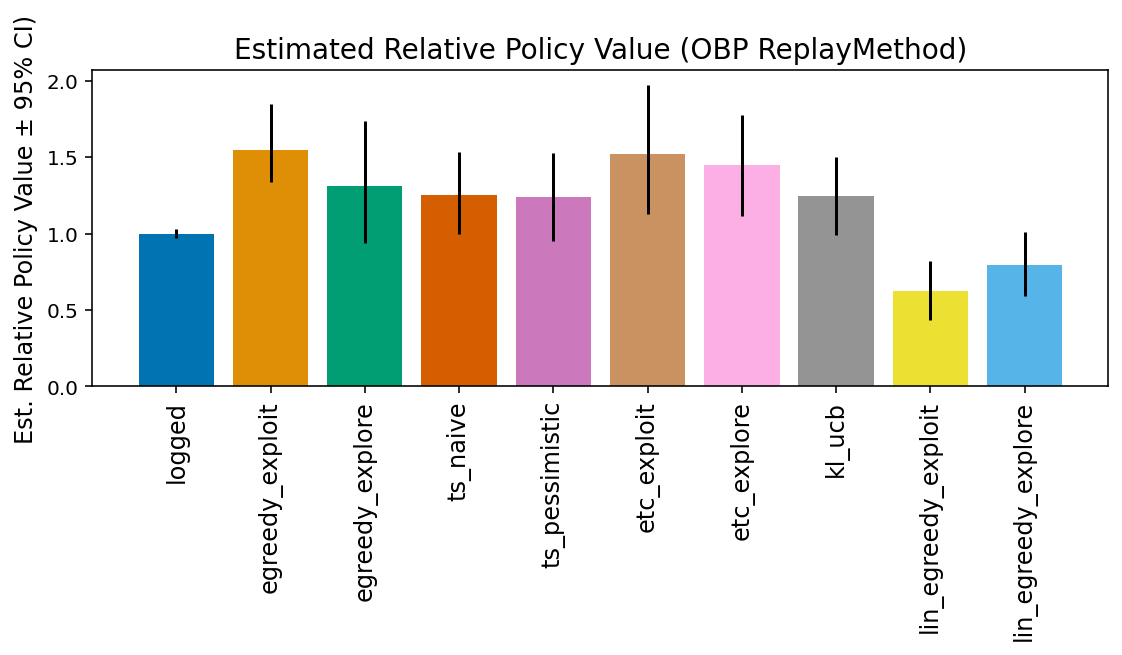

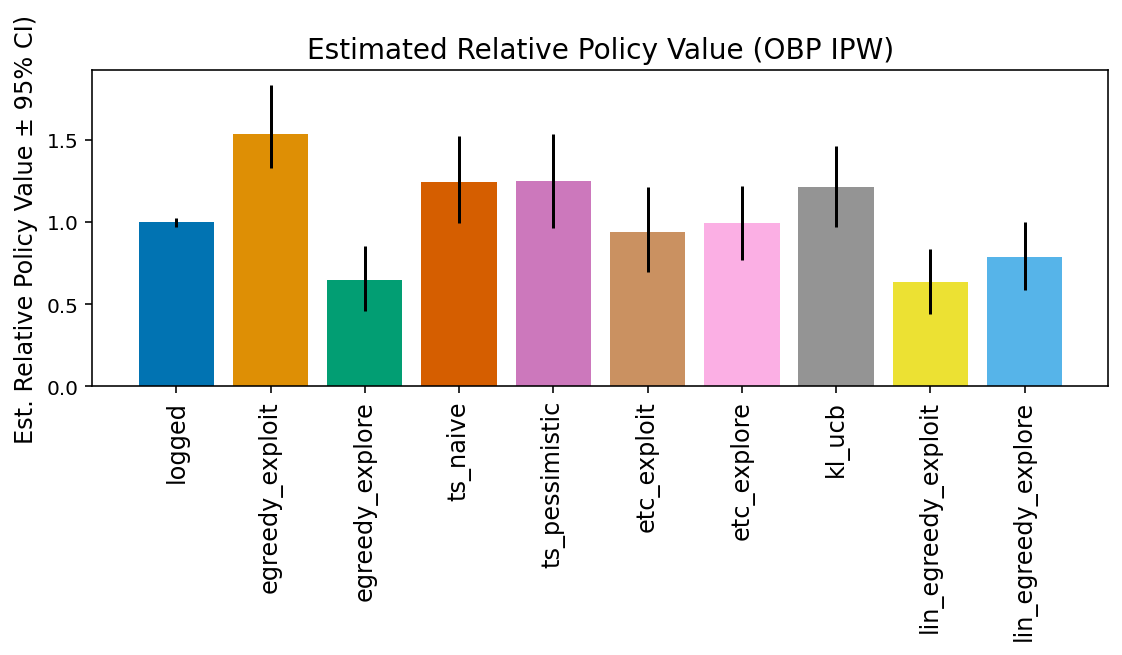

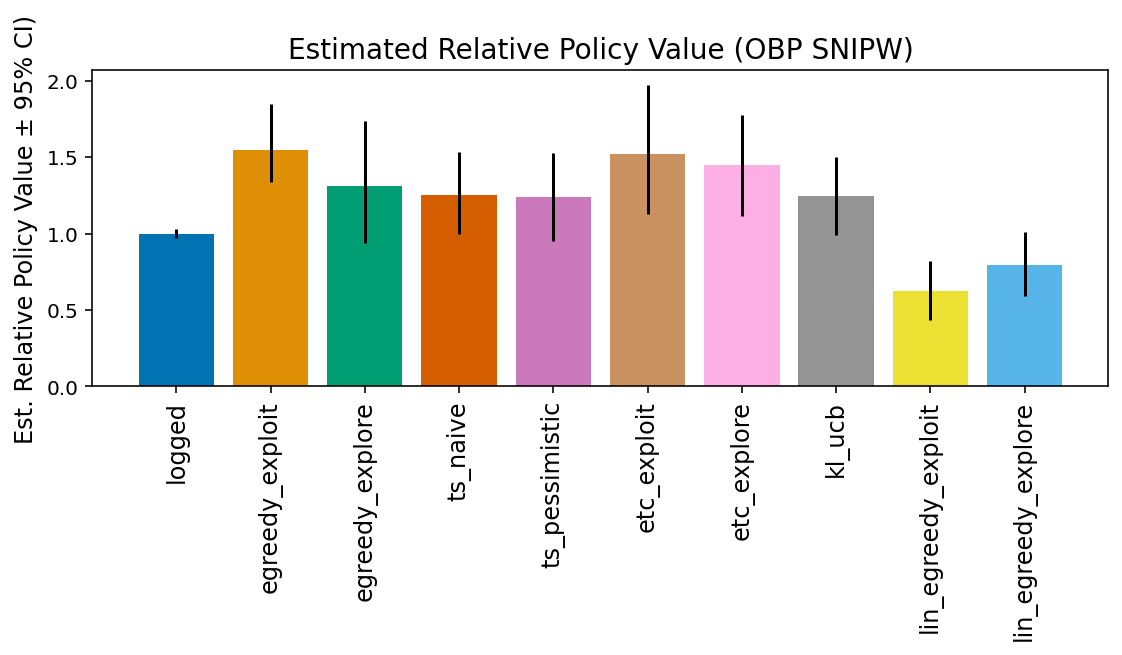

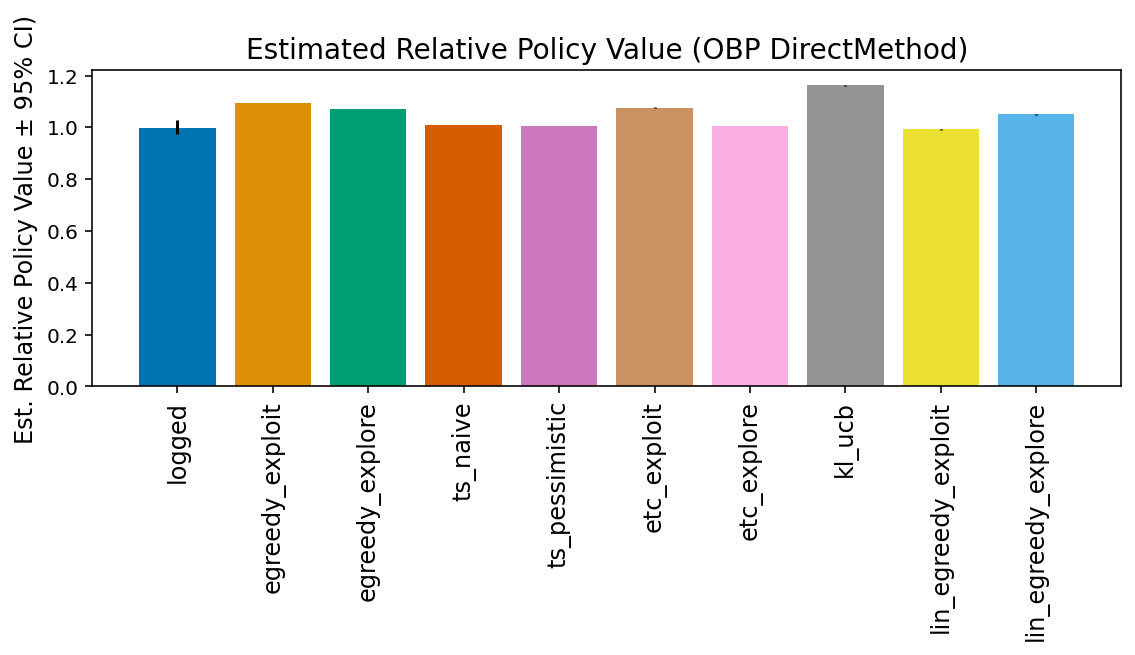

In [21]:
for estimator in estimators:
    fig, ax = plt.subplots(figsize=(8, 4.5))
    ax.bar(x=range(10), height=means[estimator], yerr=yerr[estimator].T, color=pal)
    ax.set_xticks(range(10))
    ax.set_xticklabels([policy for policy in policies], rotation=90, size=12)
    ax.set_ylabel(f"Est. Relative Policy Value ± 95% CI)", size=12)
    if estimator[0] == "I":
        estimator = "IPW"
    elif estimator[0] == "S":
        estimator = "SNIPW"
    ax.set_title(f"Estimated Relative Policy Value (OBP {estimator})", size=14)
    fig.tight_layout()
    plt.savefig(f"../figures/obp_relative_{estimator.lower()}", dpi=300)

Back to Deezer:

In [22]:
summaries_deezer = {}
for policy, summary in deezer_a["reward_summary"].items():
    summaries_deezer[policy] = summary
for policy, summary in deezer_b["reward_summary"].items():
    summaries_deezer[policy] = summary

summaries_deezer["lin_egreedy_exploit"] = summaries_deezer["linear_epsilon_greedy_0.01"]
del summaries_deezer["linear_epsilon_greedy_0.01"]
summaries_deezer["lin_egreedy_explore"] = summaries_deezer["linear_epsilon_greedy_0.1"]
del summaries_deezer["linear_epsilon_greedy_0.1"]
summaries_deezer["kl_ucb"] = summaries_deezer["kl_ucp"]
del summaries_deezer["kl_ucp"]
summaries_deezer["seg_kl_ucb"] = summaries_deezer["seg_kl_ucp"]
del summaries_deezer["seg_kl_ucp"]

In [23]:
# split into context free and contextual
summaries_deezer_contextfree = {
    policy_name: df
    for policy_name, df in summaries_deezer.items()
    if policy_name[:3] not in ("seg", "lin")
}
summaries_deezer_contextual = {
    policy_name: df
    for policy_name, df in summaries_deezer.items()
    if (policy_name[:3] in ("seg", "lin")) or policy_name == "random"
}

Pull out means, CIs, and errors

In [24]:
policies_deezer_contextfree = list(summaries_deezer_contextfree.keys())
means_deezer_contextfree = []
cis_deezer_contextfree = []
yerr_deezer_contextfree = []
for policy, summary in summaries_deezer_contextfree.items():
    means_deezer_contextfree.append(summary["mean"])
    cis_deezer_contextfree.append((summary["95.0% CI (lower)"], summary["95.0% CI (upper)"]))

In [25]:
policies_deezer_contextual = list(summaries_deezer_contextual.keys())
means_deezer_contextual = []
cis_deezer_contextual = []
yerr_deezer_contextual = []
for policy, summary in summaries_deezer_contextual.items():
    means_deezer_contextual.append(summary["mean"])
    cis_deezer_contextual.append((summary["95.0% CI (lower)"], summary["95.0% CI (upper)"]))

Make all means, CIs, and errors relative

In [26]:
baseline = summaries_deezer["random"]["mean"]
cis_deezer_contextfree = np.array(cis_deezer_contextfree) / baseline
means_deezer_contextfree = np.array(means_deezer_contextfree) / baseline
yerr_deezer_contextfree = np.abs(
    np.tile(means_deezer_contextfree, (2, 1)).T - cis_deezer_contextfree
)

In [27]:
cis_deezer_contextual = np.array(cis_deezer_contextual) / baseline
means_deezer_contextual = np.array(means_deezer_contextual) / baseline
yerr_deezer_contextual = np.abs(
    np.tile(means_deezer_contextual, (2, 1)).T - cis_deezer_contextual
)

Plot

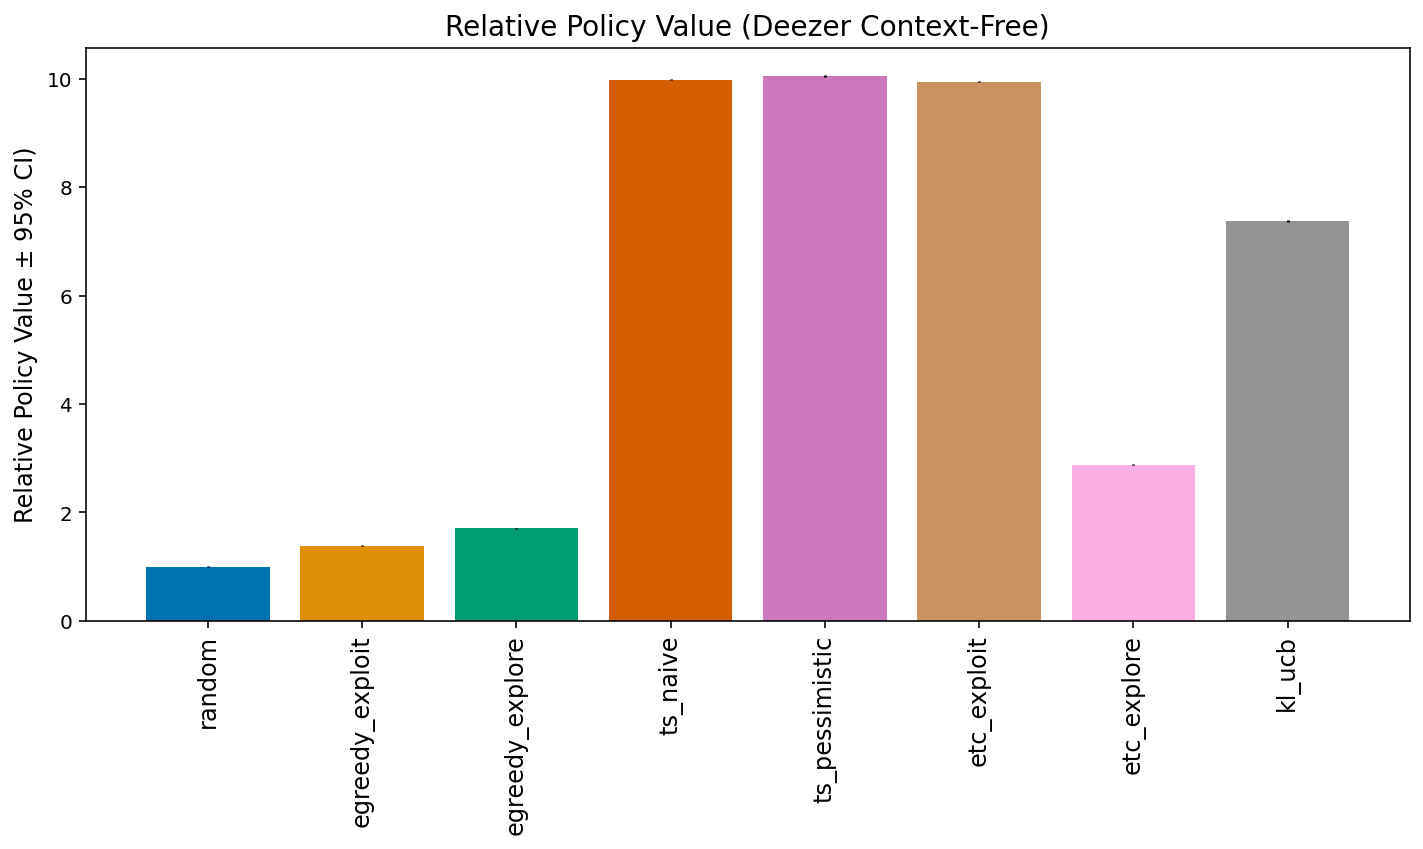

In [28]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(
    x=range(8),
    height=means_deezer_contextfree,
    yerr=yerr_deezer_contextfree.T,
    color=pal,
)
ax.set_xticks(range(8))
ax.set_xticklabels(
    [policy for policy in policies_deezer_contextfree], rotation=90, size=12
)
ax.set_ylabel(f"Relative Policy Value ± 95% CI)", size=12)
ax.set_title(f"Relative Policy Value (Deezer Context-Free)", size=14)
fig.tight_layout()
plt.savefig(f"../figures/deezer_relative_cf.png", dpi=300)

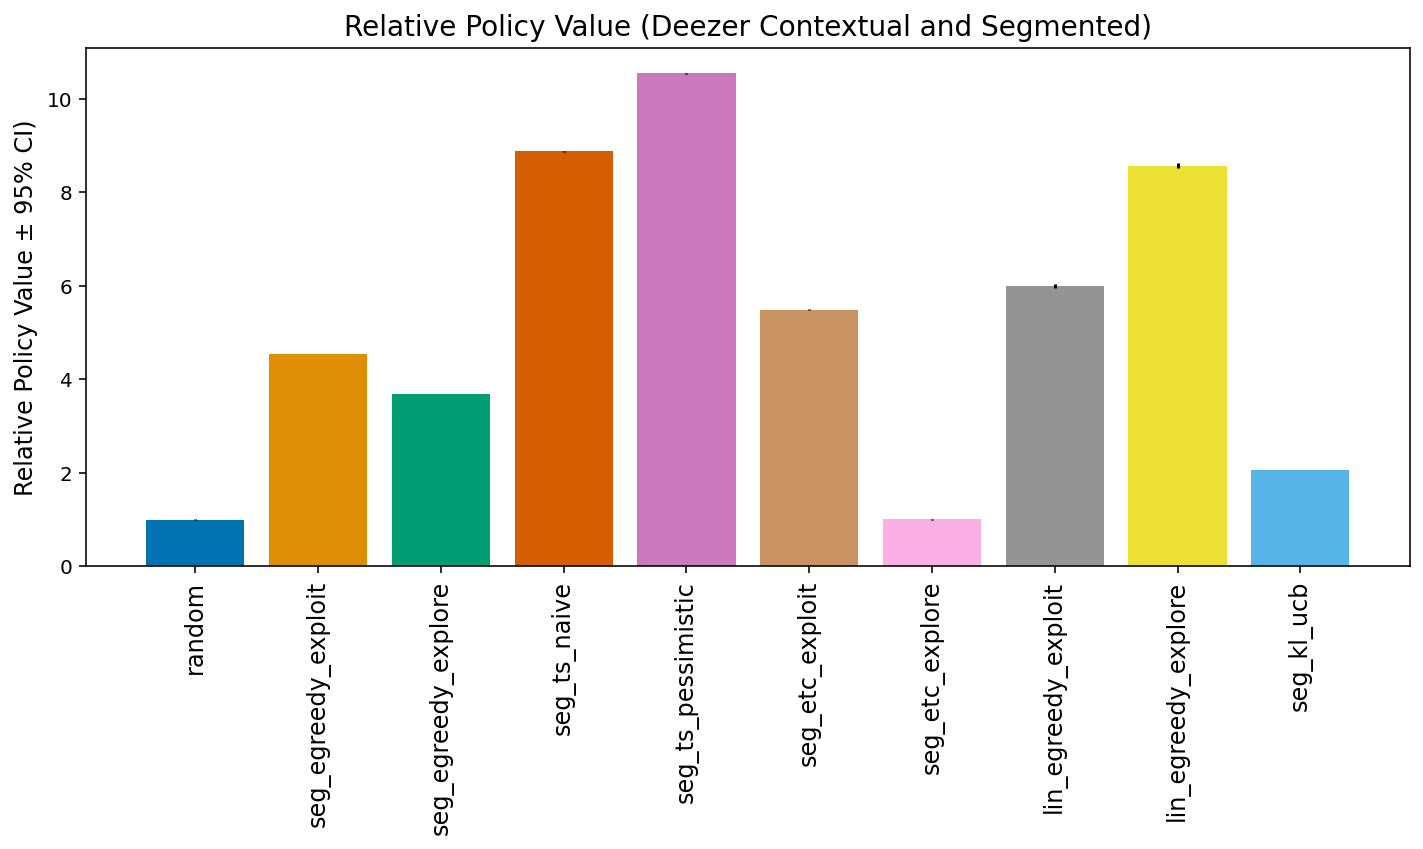

In [29]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(
    x=range(10),
    height=means_deezer_contextual,
    yerr=yerr_deezer_contextual.T,
    color=pal,
)
ax.set_xticks(range(10))
ax.set_xticklabels(
    [policy for policy in policies_deezer_contextual], rotation=90, size=12
)
ax.set_ylabel(f"Relative Policy Value ± 95% CI)", size=12)
ax.set_title(f"Relative Policy Value (Deezer Contextual and Segmented)", size=14)
fig.tight_layout()
plt.savefig(f"../figures/deezer_relative_con.png", dpi=300)

<BarContainer object of 80 artists>

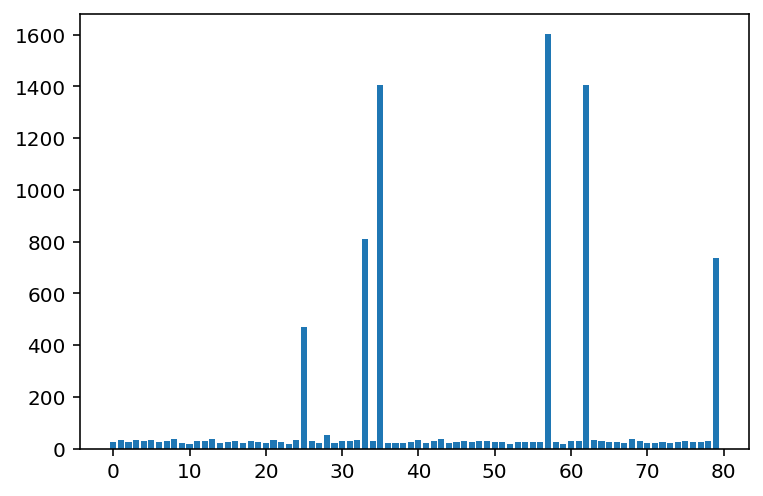

In [44]:
plt.bar(x=range(80),height=obp["policies"][1][0].action_counts)

In [42]:
obp["policies"]

[(EpsilonGreedy(n_actions=80, len_list=3, batch_size=1, random_state=1, epsilon=0.01, policy_name='egreedy_exploit'),
  {}),
 (EpsilonGreedy(n_actions=80, len_list=3, batch_size=1, random_state=1, epsilon=0.1, policy_name='egreedy_explore'),
  {}),
 (BernoulliTS(n_actions=80, len_list=3, batch_size=1, random_state=1, alpha=1, beta=1, is_zozotown_prior=False, campaign=None, policy_name='ts_naive'),
  {}),
 (BernoulliTS(n_actions=80, len_list=3, batch_size=1, random_state=1, alpha=1, beta=100, is_zozotown_prior=False, campaign=None, policy_name='ts_pessimistic'),
  {}),
 (LinEpsilonGreedy(dim=26, n_actions=80, len_list=3, batch_size=1, alpha_=1.0, lambda_=1.0, random_state=1, epsilon=0.01),
  {}),
 (LinEpsilonGreedy(dim=26, n_actions=80, len_list=3, batch_size=1, alpha_=1.0, lambda_=1.0, random_state=1, epsilon=0.1),
  {}),
 (ExploreThenCommit(n_actions=80, len_list=3, batch_size=1, random_state=1, min_n=20, policy_name='etc_exploit'),
  {}),
 (ExploreThenCommit(n_actions=80, len_list=3,

<BarContainer object of 80 artists>

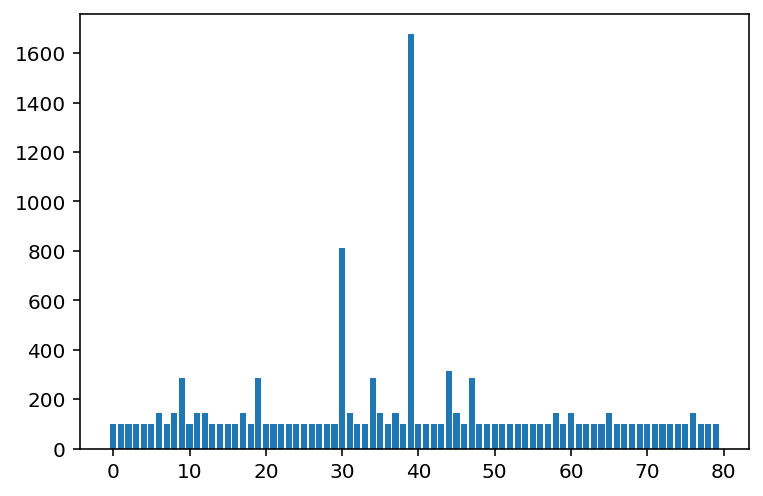

In [46]:
plt.bar(x=range(80),height=obp["policies"][-2][0].action_counts)